In [4]:
#import necessary libraries
import sys
import numpy as np
import os
import glob
import hvplot.pandas
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import plotly.express as px
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.utils import shuffle
# sklearn: basics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix, plot_roc_curve, roc_auc_score
# xgboost for sklearn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import linear_model
import pickle
import warnings
warnings.filterwarnings('ignore')


### Data Loading

In [5]:
csvfiles = []
for file in glob.glob('**20*.csv/20*.csv'):
    csvfiles.append(file)
print("total number of data file:", len(csvfiles), csvfiles)

total number of data file: 7 ['2016Q2.csv\\2016Q2.csv', '2016Q3.csv\\2016Q3.csv', '2016Q4.csv\\2016Q4.csv', '2017Q1.csv\\2017Q1.csv', '2017Q2.csv\\2017Q2.csv', '2017Q3.csv\\2017Q3.csv', '2017Q4.csv\\2017Q4.csv']


In [6]:
#read all the files and concatenate dataframe
cb_df = pd.DataFrame()
for csvfile in csvfiles:
    df = pd.read_csv(csvfile, low_memory=False)
    print(csvfile, "File shape is", df.shape)
    cb_df = pd.concat([cb_df, df], axis=0)
print("Combine file shape is", cb_df.shape)

2016Q2.csv\2016Q2.csv File shape is (48927, 55)
2016Q3.csv\2016Q3.csv File shape is (49560, 55)
2016Q4.csv\2016Q4.csv File shape is (51773, 55)
2017Q1.csv\2017Q1.csv File shape is (48389, 55)
2017Q2.csv\2017Q2.csv File shape is (52725, 55)
2017Q3.csv\2017Q3.csv File shape is (61350, 55)
2017Q4.csv\2017Q4.csv File shape is (59324, 55)
Combine file shape is (372048, 55)


### Target Selection

In [14]:
print(cb_df.shape)
cb_df['loan_status'].value_counts()

(372048, 55)


Current               225369
Fully Paid            103120
Charged Off            30640
Late (31-120 days)      7356
In Grace Period         3583
Late (16-30 days)       1980
Name: loan_status, dtype: int64

In [15]:
#current, in Grace period is not useful as the debt is on-going
df = cb_df[(cb_df['loan_status'] == 'Fully Paid') | (cb_df['loan_status'] == 'Charged Off') | (cb_df['loan_status'] == 'Late (31-120 days)') | (cb_df['loan_status'] == 'Late (16-30 days)')]
print(df.shape)

(143096, 55)


<AxesSubplot:xlabel='loan_status', ylabel='count'>

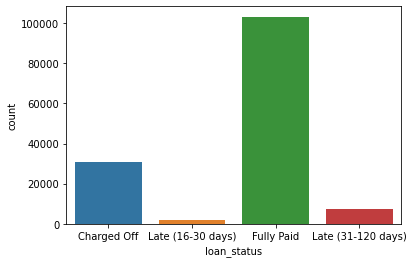

In [16]:
sns.countplot(x=df['loan_status'], data=df)

<AxesSubplot:xlabel='loan_status', ylabel='count'>

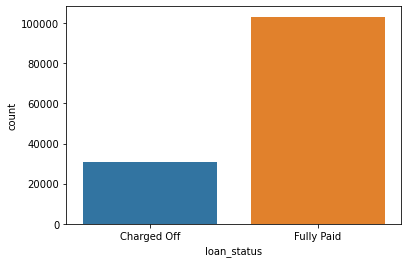

In [17]:
df = cb_df[(cb_df['loan_status'] == 'Fully Paid') | (cb_df['loan_status'] == 'Charged Off')]
sns.countplot(x=df['loan_status'], data=df)

### Dropping Features with High Porition Missing Values

Percentage of non-null values for features are:


Text(0, 0.5, 'Non-Missing Values Percentage')

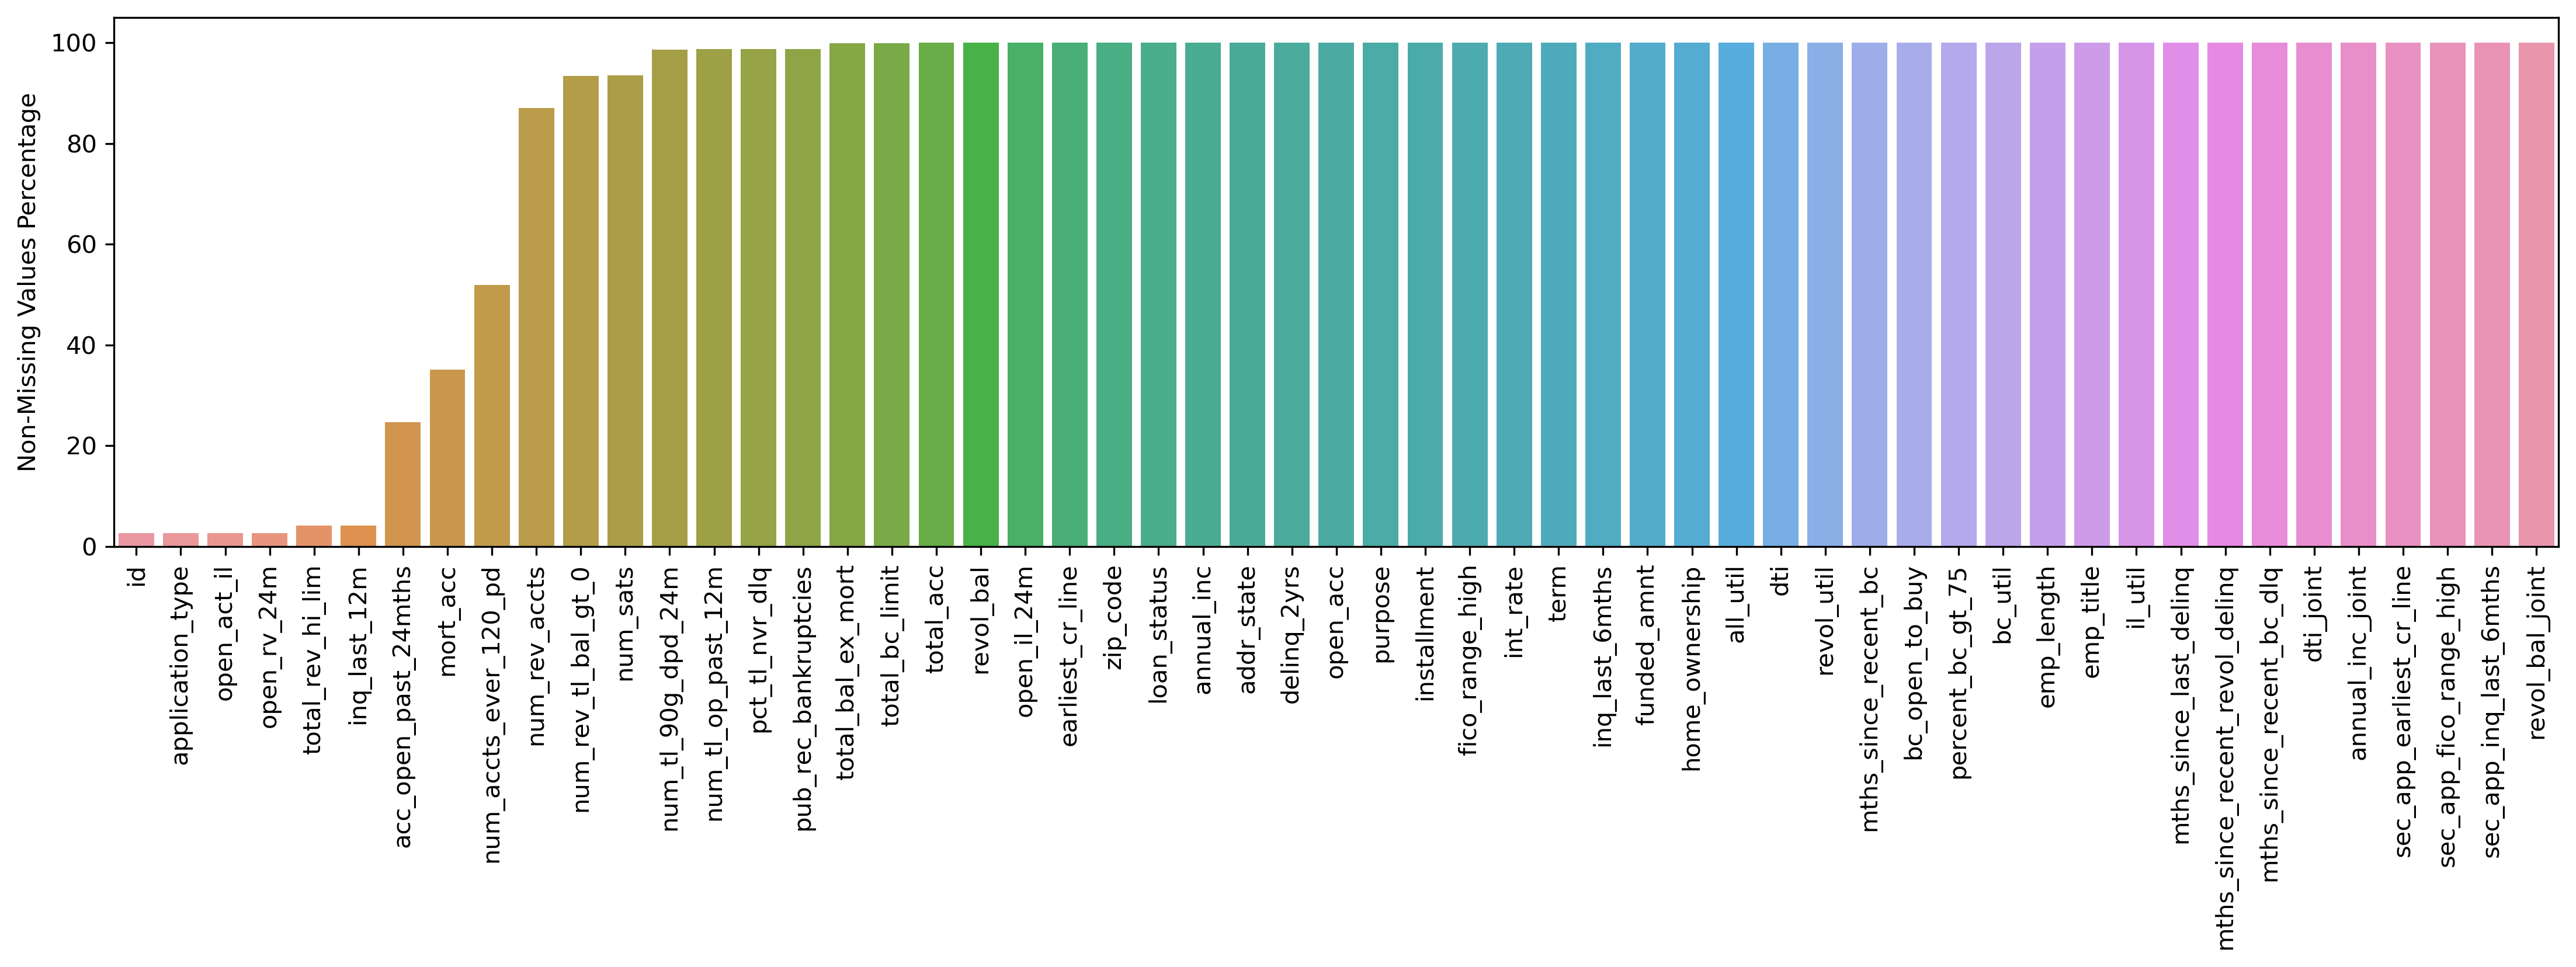

In [18]:
#missing values are observed from columns 
print("Percentage of non-null values for features are:")
#((df.isnull().sum()/len(df))).sort_values(ascending=False)
plt.figure(figsize=(18,4),dpi=300)
# y contains the % of missing values od each column and x is the index of the series in above cell
sns.barplot(y=((1 - df.isnull().sum()/len(df))*100).sort_values(), x=((df.isnull().sum()/len(df))*100).sort_values().index) 
plt.xticks(rotation=90)
plt.ylabel("Non-Missing Values Percentage")

In [19]:
#xgboost does not need to fill N/A values, high some tolerance for missing values, only drop the ones with 70% or more missing values
remove_col2 = df.columns[((df.isnull().sum()/len(df))*100 >70 )].to_list()
keep_col2 = [elem for elem in df.columns if elem not in remove_col2]

df = df[keep_col2]

In [20]:
#create binary for loan status as the prediction target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
x = df['loan_status']
y = label_encoder.fit_transform(x)
df['loan_status_target'] = y
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133760 entries, 0 to 59304
Data columns (total 49 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              133760 non-null  int64  
 1   funded_amnt                     133760 non-null  int64  
 2   term                            133760 non-null  object 
 3   int_rate                        133760 non-null  object 
 4   installment                     133760 non-null  float64
 5   emp_title                       124923 non-null  object 
 6   emp_length                      125025 non-null  object 
 7   home_ownership                  133760 non-null  object 
 8   annual_inc                      133760 non-null  float64
 9   loan_status                     133760 non-null  object 
 10  purpose                         133760 non-null  object 
 11  zip_code                        133760 non-null  object 
 12  addr_state       

## Feature Engineering

### Object Features



In [21]:
obj_col = df.select_dtypes(include='object').columns
int_col = df.select_dtypes(include='int').columns
float_col = df.select_dtypes(include='float').columns

In [22]:
df[obj_col].head(3)

,term,int_rate,emp_title,emp_length,home_ownership,loan_status,purpose,zip_code,addr_state,earliest_cr_line,revol_util,application_type
0,36 months,10.75%,Technician,10+ years,RENT,Charged Off,debt_consolidation,330xx,FL,Jun-97,23.80%,Individual
4,36 months,19.99%,Payroll Specialist,10+ years,RENT,Charged Off,other,956xx,CA,Nov-88,88%,Individual
5,36 months,11.47%,Guest Srvices,< 1 year,RENT,Charged Off,debt_consolidation,900xx,CA,Nov-04,28.40%,Individual


Covert to Numerical features
- "int_rate"
- "revol_util" "
- "earlist_cr_line"
- "term" 
- "emp_length"

In [23]:
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float') / 100.0
df['revol_util'] = df['revol_util'].str.rstrip('%').astype('float') / 100.0
df['term'] = df['term'].str.rstrip('months').astype(int)

In [24]:
#function use to convert month year feature
def convert_year(m_y_string):
    add = "19" if int(m_y_string[-2:]) > 50 else "20"
    #print(m_y_string[0:3] + "-" + add + m_y_string[-2:])
    return datetime.strptime(m_y_string[0:3] + "-" + add + m_y_string[-2:], '%b-%Y')


In [25]:
a = pd.to_datetime(df['earliest_cr_line'].apply(lambda x: convert_year(x)))
df['earliest_cr_line'] = ((pd.to_datetime("2015-12-31") - a) / np.timedelta64(1, 'M')).astype(int)
df['emp_length'] = df['emp_length'].str.rstrip('years').replace(['10+ ','< 1 '],['15', '0.5']).astype(float)

In [26]:
df[obj_col].describe(include='all')

,term,int_rate,emp_title,emp_length,home_ownership,loan_status,purpose,zip_code,addr_state,earliest_cr_line,revol_util,application_type
count,133760.000000,133760.000000,124923,125025.000000,133760,133760,133760,133760,133760,133760.000000,133668.000000,133760
unique,NaN,NaN,46832,NaN,5,2,12,880,50,NaN,NaN,2
top,NaN,NaN,Manager,NaN,MORTGAGE,Fully Paid,debt_consolidation,945xx,CA,NaN,NaN,Individual
freq,NaN,NaN,2359,NaN,66724,103120,76475,1552,19007,NaN,NaN,128230
mean,41.440730,0.138753,NaN,7.829386,NaN,NaN,NaN,NaN,NaN,182.521516,0.469101,NaN
std,10.048718,0.054227,NaN,5.819410,NaN,NaN,NaN,NaN,NaN,90.115323,0.247054,NaN
min,36.000000,0.053200,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,13.000000,0.000000,NaN
25%,36.000000,0.104200,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,123.000000,0.279000,NaN
50%,36.000000,0.127900,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,164.000000,0.460000,NaN
75%,36.000000,0.162900,NaN,15.000000,NaN,NaN,NaN,NaN,NaN,228.000000,0.653000,NaN


For the remained categorical features, will have to apply one-hot encoding. Have to drop emp_title, and zip code as they have 
so many different values, will results in huge number of columns.

In [27]:
df = df.drop(['emp_title', 'zip_code'], axis=1)

In [28]:
obj_col = df.select_dtypes(include='object').columns
int_col = df.select_dtypes(include='int').columns
float_col = df.select_dtypes(include='float').columns

Display bar plots for categorical features

In [29]:
cb_plot = []
cb_obj = []

for col in df[obj_col].columns.drop('loan_status'):
    full_paid = df.loc[df['loan_status']=='Fully Paid', col].value_counts()
    full_paid_plot = full_paid.hvplot.bar() 
    
    charged_off = df.loc[df['loan_status']=='Charged Off', col].value_counts() 
    charged_off_plot = charged_off.hvplot.bar()
    
    cb_plot.append((full_paid_plot * charged_off_plot).opts(
        title="Loan Status by " + col, xlabel=col, ylabel='Count',
        width=1000, height=250, legend_cols=2, legend_position='top_right', xrotation=90))
    
    df_cat = pd.concat([pd.DataFrame(full_paid).rename(columns={col: 'full_paid'}), pd.DataFrame(charged_off).rename(columns={col: 'charged_off'})], axis=1)
    df_cat['paid_ratio'] = round(df_cat['full_paid'] / (df_cat['full_paid'] + df_cat['charged_off']) * 100 , 2)
    df_cat['charged_off_ratio'] = round(df_cat['charged_off'] / (df_cat['full_paid'] + df_cat['charged_off']) * 100 , 2)
    #cb_perc.append(charged_off / (charged_off + full_paid))
    cb_obj.append(df_cat)
    

In [31]:
print(obj_col)
num = 0
print("Total data percentage of charged off {}% ".format(round(len(df[df['loan_status'] == 'Charged Off'])/len(df)*100, 2)))
print("vs Percentange of charged off/total for different catelogue: \n")
print(cb_obj[num])
cb_plot[num]

Index(['home_ownership', 'loan_status', 'purpose', 'addr_state',
       'application_type'],
      dtype='object')
Total data percentage of charged off 22.91% 
vs Percentange of charged off/total for different catelogue: 

          full_paid  charged_off  paid_ratio  charged_off_ratio
MORTGAGE      54171      12553.0       81.19              18.81
RENT          36513      14258.0       71.92              28.08
OWN           12348       3810.0       76.42              23.58
ANY              87         19.0       82.08              17.92
NONE              1          NaN         NaN                NaN


:Overlay
   .Bars.Home_ownership.I  :Bars   [index]   (home_ownership)
   .Bars.Home_ownership.II :Bars   [index]   (home_ownership)

### Integer Features

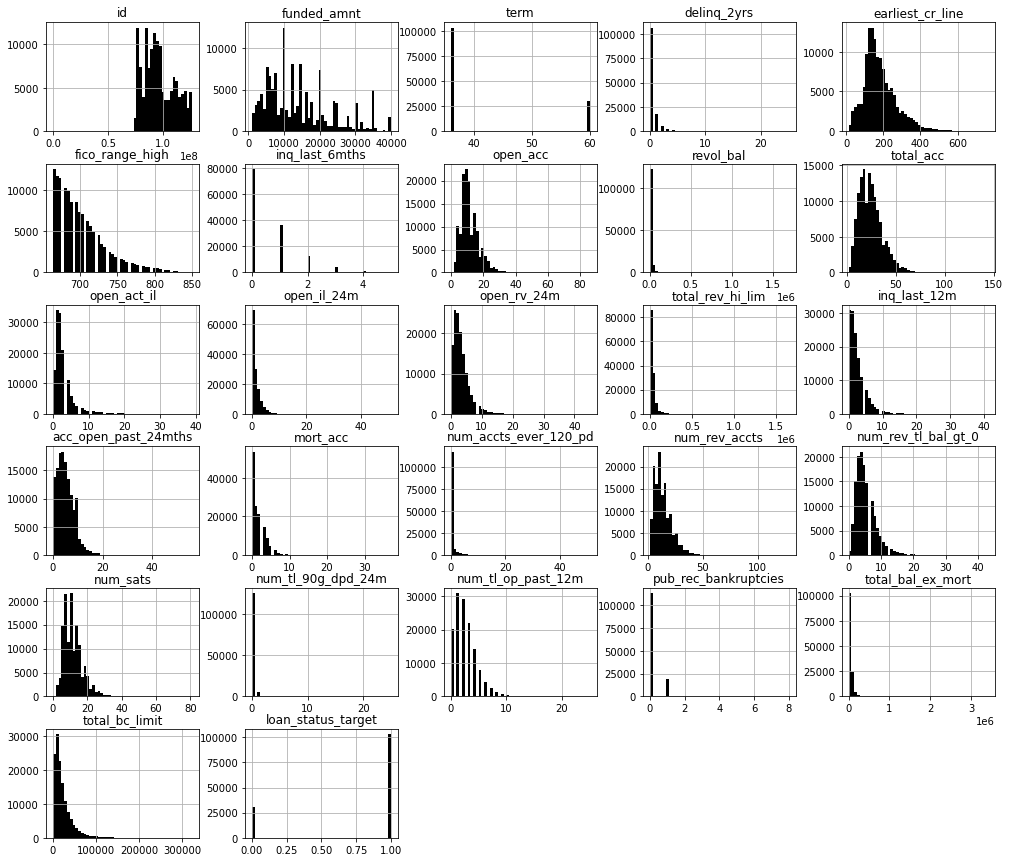

In [32]:
fig = df[int_col].hist(bins=50, figsize=(17,15), color="black")
plt.show()

In [33]:
col = 'total_bal_ex_mort'
print(df[col].describe(percentiles=[0.999]))
#df[[col]].value_counts()

count    1.337600e+05
mean     5.161870e+04
std      5.001919e+04
min      0.000000e+00
50%      3.852600e+04
99.9%    4.370475e+05
max      3.408095e+06
Name: total_bal_ex_mort, dtype: float64


After plot value distributions:
- ID should be removed
- total_bal_ex_mort will need to drop outliers
    

In [41]:
print(df.shape)
df = df.drop('id', axis=1)
df = df[df['total_bal_ex_mort'] < 4.3e+05]
print(df.shape)

(132745, 47)
(132611, 46)


### Float Features

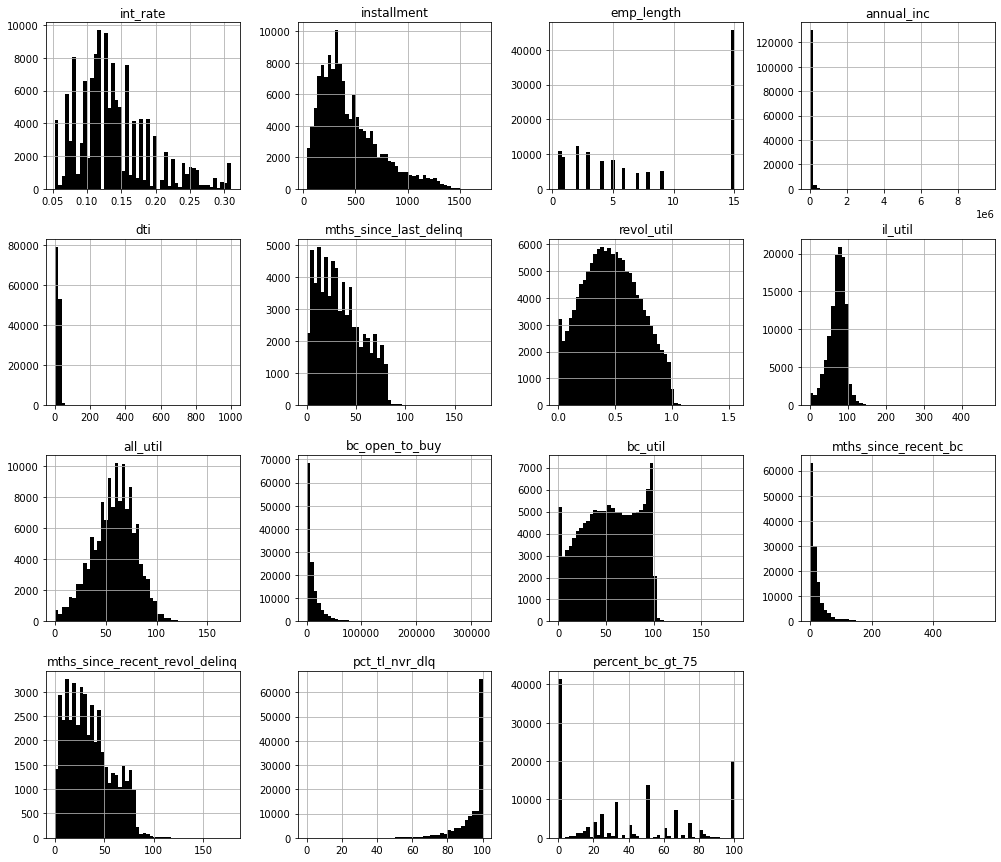

In [34]:
fig = df[float_col].hist(bins=50, figsize=(17,15), color="black")
plt.show()

Outliers exist for all float features. Will apply some detection and removal

In [35]:
col = 'mths_since_recent_revol_delinq'
print(df[col].describe(percentiles=[0.0001, 0.999]))
remove_boundary_dict = {'dti': 94, 'annual_inc': 6e+05, 'mths_since_last_delinq': 95, 'revol_util': 1.05,
'il_util': 152, 'all_util': 123, 'bc_open_to_buy': 142300, 'bc_util': 107, 'mths_since_recent_bc':273, 'mths_since_recent_revol_delinq':108}
#pct_tl_nvr_dlq: remove 0


count    47041.000000
mean        35.202696
std         22.409068
min          0.000000
0.01%        0.000000
50%         32.000000
99.9%      106.960000
max        178.000000
Name: mths_since_recent_revol_delinq, dtype: float64


In [36]:
#remove outliers for all float features
print(df.shape)
df_rm = df.copy()
for item in remove_boundary_dict:
    df_rm = df_rm[(df_rm[item] < remove_boundary_dict[item]) | (df_rm[item].isnull())]
print(df_rm.shape)
df = df_rm

(133760, 47)
(132747, 47)


In [42]:
df = df[df['pct_tl_nvr_dlq']!=0]
print(df.shape)

(132611, 46)


### One-Hot Encoding for Catagorical Features

In [43]:
#Update float, integer and categorical features, baseline model will be Xgboost and no need to convert to one-hot-encoding for now
obj_col = df.select_dtypes(include='object').columns
int_col = df.select_dtypes(include='int').columns
float_col = df.select_dtypes(include='float').columns

In [44]:
df_copy = df.copy()
for col in obj_col.drop('loan_status'):
    add_dummies = pd.get_dummies(df_copy[col], drop_first=True)
    df_copy = pd.concat([df_copy, add_dummies], axis=1)
print(df.shape)
print(df_copy.shape)

(132611, 46)
(132611, 110)


### Correlation Study

<AxesSubplot:>

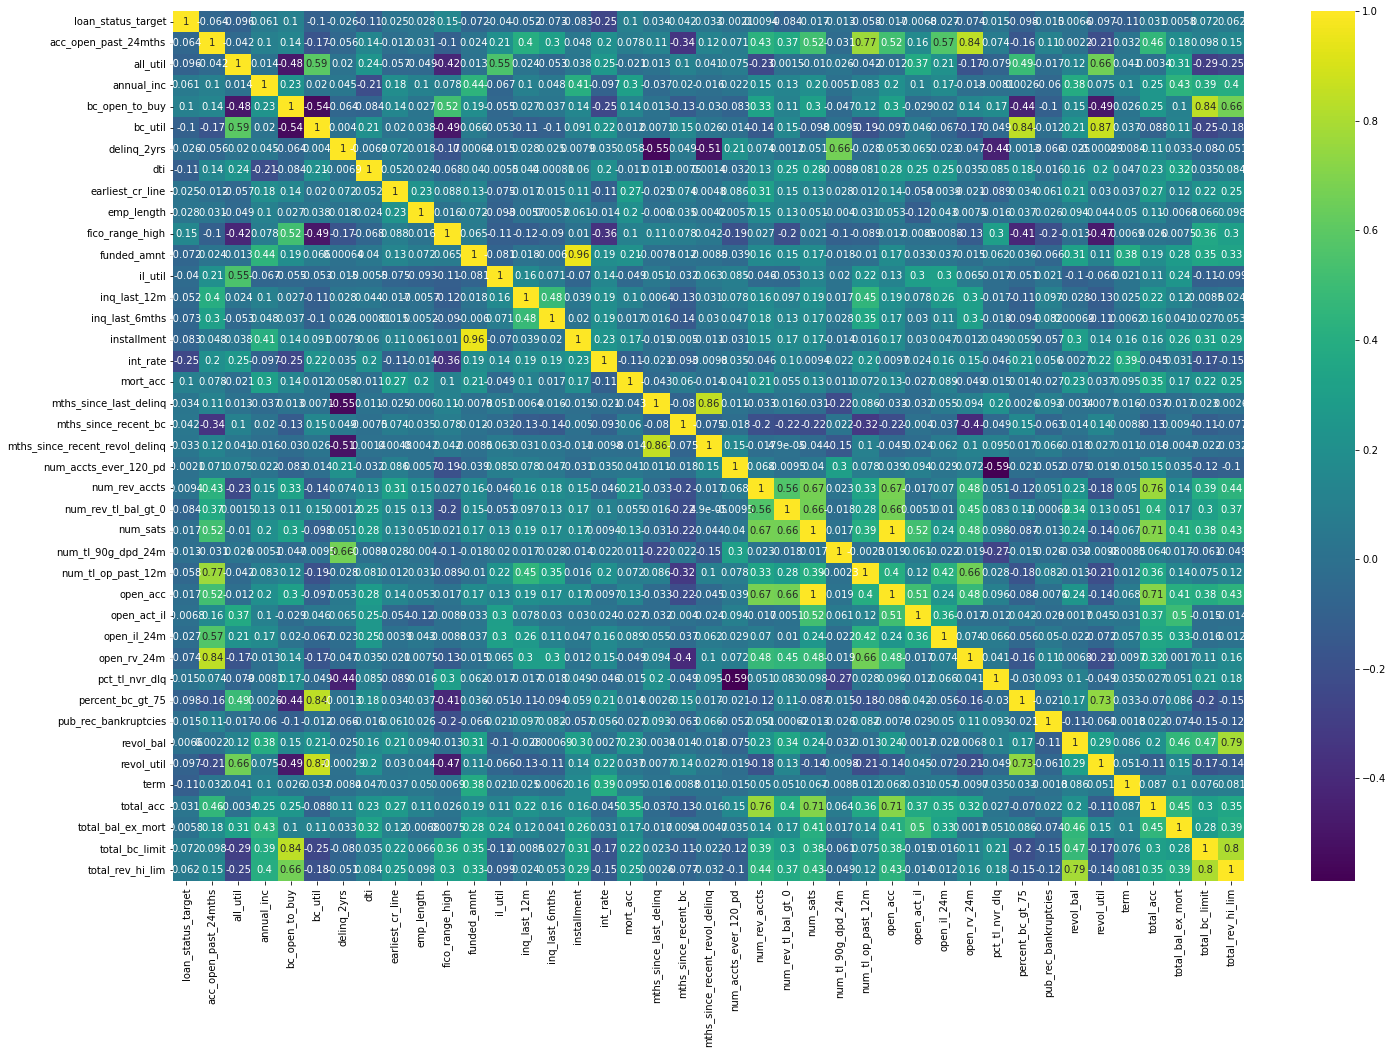

In [47]:
df = df.reindex(columns=sorted(df.columns))
df = df.reindex(columns=(['loan_status_target'] + list([a for a in df.columns if a != 'loan_status_target']) ))
plt.figure(figsize=(24, 16))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

Perfect correlation are observed for:
- loan_amnt & installment
- num_sats & open_acc

In [49]:
num_sats = df.hvplot.hist(
    y='num_sats', by='loan_status', subplots=False, 
    width=350, height=300, bins=50, alpha=0.4, 
    title="Num_sats by Loan Status", 
    xlabel='Num_sats', ylabel='Counts', legend='top'
)

open_acc = df.hvplot.hist(
    y='open_acc', by='loan_status', subplots=False, 
    width=350, height=300, bins=50, alpha=0.4, 
    title="Open Acc by Loan Status", 
    xlabel='Open Acc', ylabel='Counts', legend='top'
)

In [50]:
num_sats + open_acc

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [num_sats]   (num_sats_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [open_acc]   (open_acc_count)

### XGboost Model Building

In [51]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [52]:
def model_train_val(x, y, model_type='xgb', xgb_para=None):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
   
    if not xgb_para:
        model = XGBClassifier()
    else:
        model = xgb.XGBClassifier(**xgb_para)
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    print_score(y_train, y_pred_train, train=True)
    print_score(y_test, y_pred, train=False)
    
    return [y_pred, y_test, x_test], model

In [53]:
#1 is full-paid, 0 is charged-off
obj_col = df_copy.select_dtypes(include='object').columns
df_x = df_copy.drop(columns = list(obj_col) + ['loan_status_target'])
df_y = df_copy['loan_status_target']

#### Baseline Model

In [54]:
test, model = model_train_val(df_x, df_y)

Train Result:
Accuracy Score: 81.95%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.803124      0.820888  0.819452       0.812006       0.816810
recall         0.282899      0.979335  0.819452       0.631117       0.819452
f1-score       0.418413      0.893139  0.819452       0.655776       0.784154
support    24355.000000  81733.000000  0.819452  106088.000000  106088.000000
_______________________________________________
Confusion Matrix: 
 [[ 6890 17465]
 [ 1689 80044]]

Test Result:
Accuracy Score: 77.61%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.521008      0.795849  0.776119      0.658429      0.733488
recall        0.164839      0.955523  0.776119      0.560181      0.776119
f1-score      0.250442      0.868407  0.776119      0.559424      0.72

- The data is unbalanced for two classed, and the target is to create a high recall model, which is able to provide high-confidence for the predicted full-paid class
- One example is shown below, use proba to select instances which has confidence bigger than 0.95 will result in 95% accuracy 
rate
- Senario is in future investment, if the interest rate is 10%, select instances with proba >90% will result in earning

In [55]:
prob = model.predict_proba(test[2])

In [56]:
#test[2].shape
print(len(test[0][prob[:, 1]>0.95]))
print_score(test[0][prob[:, 1] > 0.95], test[1][prob[:,1]>0.95])
#prob > 0.90

2459
Train Result:
Accuracy Score: 95.89%
_______________________________________________
CLASSIFICATION REPORT:
             0            1  accuracy    macro avg  weighted avg
precision  0.0     1.000000  0.958926     0.500000      1.000000
recall     0.0     0.958926  0.958926     0.479463      0.958926
f1-score   0.0     0.979033  0.958926     0.489516      0.979033
support    0.0  2459.000000  0.958926  2459.000000   2459.000000
_______________________________________________
Confusion Matrix: 
 [[   0    0]
 [ 101 2358]]



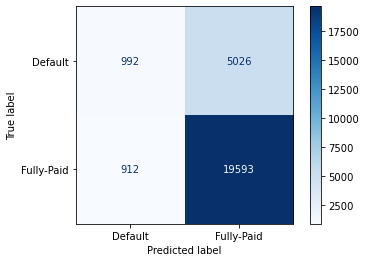

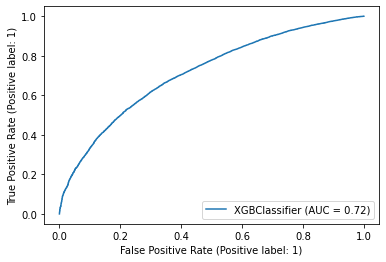

In [57]:
display = plot_confusion_matrix(
    model, test[2], test[1], 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

display = plot_roc_curve(model, test[2], test[1])

###  Feature Importances with Xgboost itself

In [58]:
feature_imp = pd.DataFrame()
feature_imp['xgboost'] = model.feature_importances_
feature_imp['feature'] = df_x.columns

<AxesSubplot:xlabel='feature'>

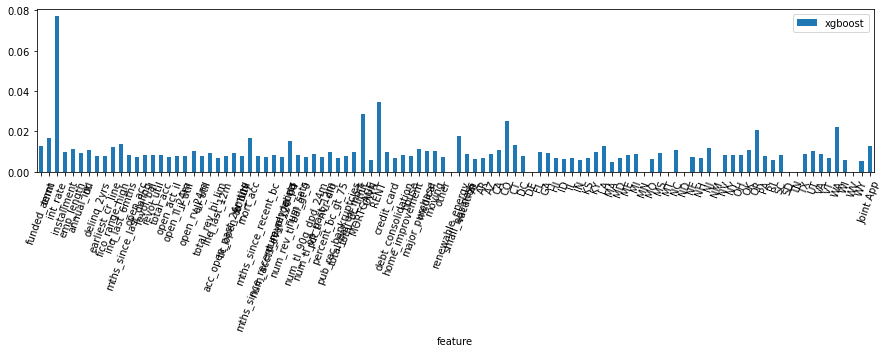

In [59]:
feature_imp.plot.bar(x='feature', y=['xgboost'], rot=70, figsize=(15,3) )

In [60]:
select_feature = [df_x.columns[i] for i, feature_imp in enumerate(model.feature_importances_) if feature_imp > 0.005]

In [61]:
test_sel, model_sel = model_train_val(df_x[select_feature], df_y)

Train Result:
Accuracy Score: 81.97%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.803951      0.821128  0.819735       0.812539       0.817184
recall         0.284048      0.979360  0.819735       0.631704       0.819735
f1-score       0.419782      0.893291  0.819735       0.656536       0.784586
support    24355.000000  81733.000000  0.819735  106088.000000  106088.000000
_______________________________________________
Confusion Matrix: 
 [[ 6918 17437]
 [ 1687 80046]]

Test Result:
Accuracy Score: 77.59%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.519013      0.796232  0.775893      0.657623      0.733332
recall        0.167830      0.954353  0.775893      0.561091      0.775893
f1-score      0.253641      0.868151  0.775893      0.560896      0.72

### Feature Importances with SHAP

In [62]:
import shap
shap.initjs()

In [63]:
explainer = shap.TreeExplainer(model=model,
                               model_output='raw',
                               feature_dependence='interventional',
                               data=test[2],
                              )

 99%|===================| 26194/26523 [07:23<00:05]        

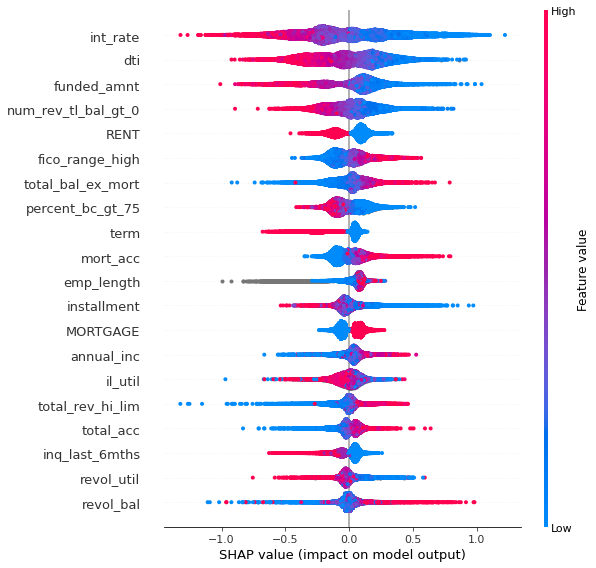

In [64]:
shap_values_all = explainer.shap_values(X=test[2])
shap.summary_plot(shap_values=shap_values_all, features=test[2])

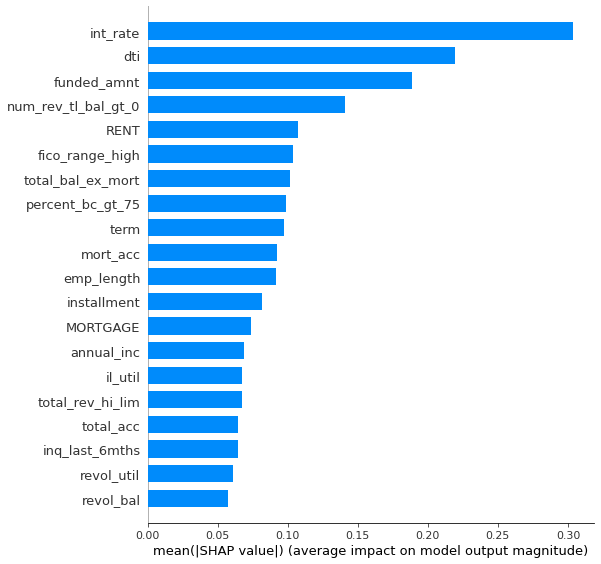

In [102]:
shap.summary_plot(shap_values_all, df_x, plot_type="bar")

<AxesSubplot:xlabel='column_name'>

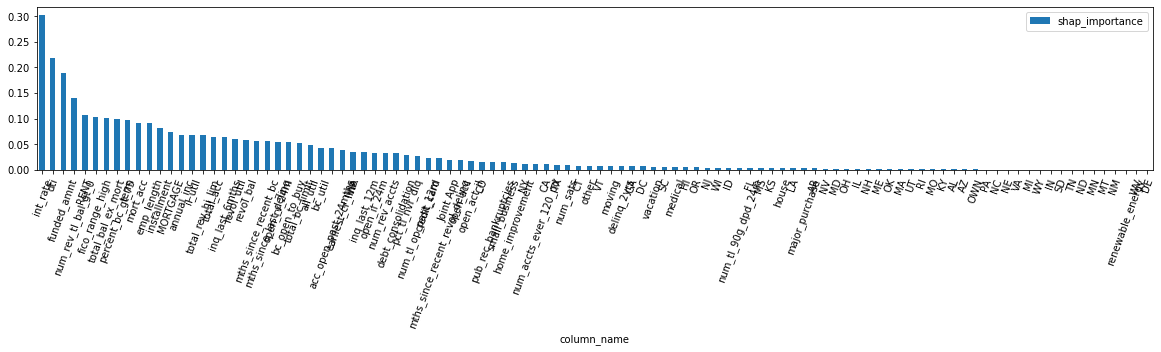

In [71]:
shap_sum = np.abs(shap_values_all).mean(axis=0)
importance_df = pd.DataFrame([df_x.columns, shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df.plot.bar(x='column_name', y=['shap_importance'], rot=70, figsize=(20,3) )

In [70]:
def shap_feature_selection(x, y, importance, cut_off=0, model_type='xgb', xgb_para=None):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
   
    if not xgb_para:
        model = XGBClassifier()
    else:
        model = xgb.XGBClassifier(**xgb_para)
    sel_feature = []
    test_acc = []
    test_roc = []
    max_acc = 0
    max_roc = 0
    max_acc_feature = []
    max_roc_feature = []
    for index, row in importance.iterrows():
        if row['shap_importance'] > cut_off:
            sel_feature.append(row['column_name'])
            model.fit(x_train[sel_feature], y_train)
            y_pred = model.predict(x_test[sel_feature])
            current_acc = accuracy_score(y_test, y_pred)
            current_roc_auc_score = roc_auc_score(y_test, model.predict_proba(x_test[sel_feature])[:, 1])
            test_acc.append(current_acc)
            test_roc.append(current_roc_auc_score)
            if current_acc > max_acc:
                max_acc = current_acc
                max_acc_feature = sel_feature.copy()
            if current_roc_auc_score > max_roc:
                max_roc = current_roc_auc_score
                max_roc_feature = sel_feature.copy()
    
    return [max_acc, max_roc, max_acc_feature], [max_roc_feature, test_acc, test_roc]

In [72]:
acc, roc = shap_feature_selection(df_x, df_y, importance_df, cut_off=0.002)

In [75]:
test_shap_acc_sel, model_shap_acc_sel = model_train_val(df_x[acc[2]], df_y)

Train Result:
Accuracy Score: 82.17%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.816028      0.822227  0.821723       0.819127       0.820804
recall         0.288483      0.980620  0.821723       0.634551       0.821723
f1-score       0.426270      0.894465  0.821723       0.660368       0.786980
support    24355.000000  81733.000000  0.821723  106088.000000  106088.000000
_______________________________________________
Confusion Matrix: 
 [[ 7026 17329]
 [ 1584 80149]]

Test Result:
Accuracy Score: 77.78%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.533016      0.796630  0.777815      0.664823      0.736817
recall        0.167664      0.956889  0.777815      0.562276      0.777815
f1-score      0.255088      0.869436  0.777815      0.562262      0.73

### Hyperparameter Tunning

In [ ]:
"""
from xgboost_classify_v3_small_error import xgb_tune_hyperparameters
X = df_x_sel
y = df_y_sel
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
train_val_test_log_file_path = './train_val_test_logs/'
xgb_hyperparams_sel, xgb_CV = xgb_tune_hyperparameters(X_train=X_train,
                                             Y_train=y_train,
                                             eval_metric='error',
                                             max_evals=10,
                                             save_to_csv_path=train_val_test_log_file_path,
                                             file_name='xgb_regression_acc.csv'
                                            )
""""""

In [81]:
xgb_hyperparams_sel = para

In [79]:
para = {'booster': 'gbtree', 'colsample_bytree': 0.8, 'eval_metric': 'error', 'gamma': 0.7, 'learning_rate': 0.155, 'max_depth': 10, 'min_child_weight': 4.0, 'objective': 'binary:logistic', 'scale_pos_weight': 2.0, 'subsample': 0.8, 'n_estimators': 399}

In [80]:
test_shap_acc_sel_para, model_shap_acc_sel_para = model_train_val(df_x[acc[2]], df_y, xgb_para=para)

Train Result:
Accuracy Score: 96.55%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      1.000000      0.957184  0.965538       0.978592       0.967014
recall         0.849887      1.000000  0.965538       0.924944       0.965538
f1-score       0.918853      0.978124  0.965538       0.948488       0.964517
support    24355.000000  81733.000000  0.965538  106088.000000  106088.000000
_______________________________________________
Confusion Matrix: 
 [[20699  3656]
 [    0 81733]]

Test Result:
Accuracy Score: 77.68%
_______________________________________________
CLASSIFICATION REPORT:
                     0             1  accuracy     macro avg  weighted avg
precision     0.536317      0.789865  0.776835      0.663091      0.732335
recall        0.121469      0.969178  0.776835      0.545324      0.776835
f1-score      0.198076      0.870382  0.776835      0.534229      0.71

### Result Interpretation

In [105]:
#select two models to compare, one with lower accuracy rate but higher recall for fully paid class
model_sel_high_recall = model_shap_acc_sel_para
model_sel = model_shap_acc_sel

In [125]:
test_proba = model_sel.predict_proba(test_shap_acc_sel[2])
test_proba_high_recall = model_sel_high_recall.predict_proba(test_shap_acc_sel_para[2])
proba = pd.DataFrame(test_proba, columns=['0', '1'])
proba_high_recall = pd.DataFrame(test_proba_high_recall, columns=['0', '1'])

In [306]:
def plot_proba(model, test):
    proba = model.predict_proba(test[2])
    f, ax= plt.subplots(sharey=True)
    ax.hist(proba[:,1], bins=50)
    ax.set_title("Full Paid Testset Probablity Distribution")
    ax.set_xlabel("Probablity")
    
    accuracy_fu = accuracy_score(test[1], test[0])
    accuracy_80 = accuracy_score(test[1][prob[:, 1] > 0.8], test[0][prob[:, 1] > 0.8])
    accuracy_90 = accuracy_score(test[1][prob[:, 1] > 0.9], test[0][prob[:, 1] > 0.9])
    plt.text(1.1, 0, f'Full data accuracy ={accuracy_fu.round(3)} with num {len(test[0])}, ', va="top")
    a = proba
    
    plt.text(1.1, 200, f'80% proba data accuracy ={accuracy_80.round(3)} with num {len(a[a[:,1]>0.8])}', va="top")
    plt.text(1.1, 400, f'90% proba data accuracy ={accuracy_90.round(3)} with num {len(a[a[:,1]>0.9])}', va="top")
         
    plt.show()
    return ax

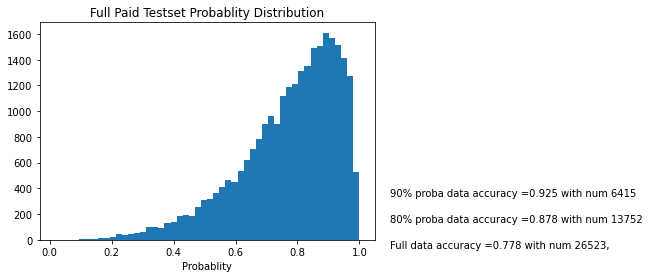

<AxesSubplot:title={'center':'Full Paid Testset Probablity Distribution'}, xlabel='Probablity'>

In [307]:
plot_proba(model_sel, test_shap_acc_sel)
#ax1.hist(proba.iloc[:, 1], bins=10)
#ax2.hist(proba_high_recall.iloc[:, 1], bins=10)

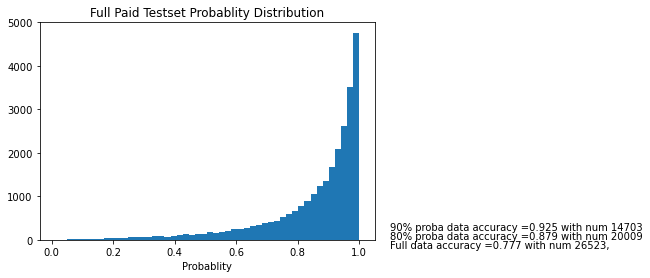

<AxesSubplot:title={'center':'Full Paid Testset Probablity Distribution'}, xlabel='Probablity'>

In [308]:
plot_proba(model_sel_high_recall, test_shap_acc_sel_para)

Summary:

- The fine-tune model has similar accuracy as the benchmark model, however, it includes more high probability instances (better deicison boundary)
- The application of the model is, for example, use 90% as the selection criteria, if the interest rate higher than 10%, the
investment tends to earn some money in the end